In [0]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install fastai==0.7.0 

     |████████████████████████████████| 122kB 2.9MB/s 
     |████████████████████████████████| 1.5MB 9.1MB/s 
     |████████████████████████████████| 496.4MB 27kB/s 
     |████████████████████████████████| 3.6MB 36.8MB/s 
     |████████████████████████████████| 61kB 20.7MB/s 
     |████████████████████████████████| 81kB 21.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: fastai 1.0.53.post2
    Uninstalling fastai-1.0.53.post2:
      Successfully uninstalled fastai-1.0.53.post2


In [0]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pylab as plot
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [10, 6]
}
plot.rcParams.update(params)

##Uploading Datasets 

In [4]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [0]:
import io
import pandas as pd
train_raw = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test_raw = pd.read_csv(io.BytesIO(uploaded['test.csv']))
#train_raw=pd.read_csv("C:/Users/Rodney/Downloads/train.csv")
#test_raw=pd.read_csv("C:/Users/Rodney/Downloads/test.csv")

In [7]:
#check the size of the train and test data

train_raw.shape, test_raw.shape

((891, 12), (418, 11))

In [8]:
#check if the data loaded properly

train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Explore the Data

In [11]:
train_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The count variable shows that 177 values are missing in the Age column. One solution is to fill in the null values with the median age. We could also impute with the mean age but the median is more robust to outlier.

In [0]:
data = train_raw
data['Died']= 1 - data['Survived']

Visualize the survival based on the gender.

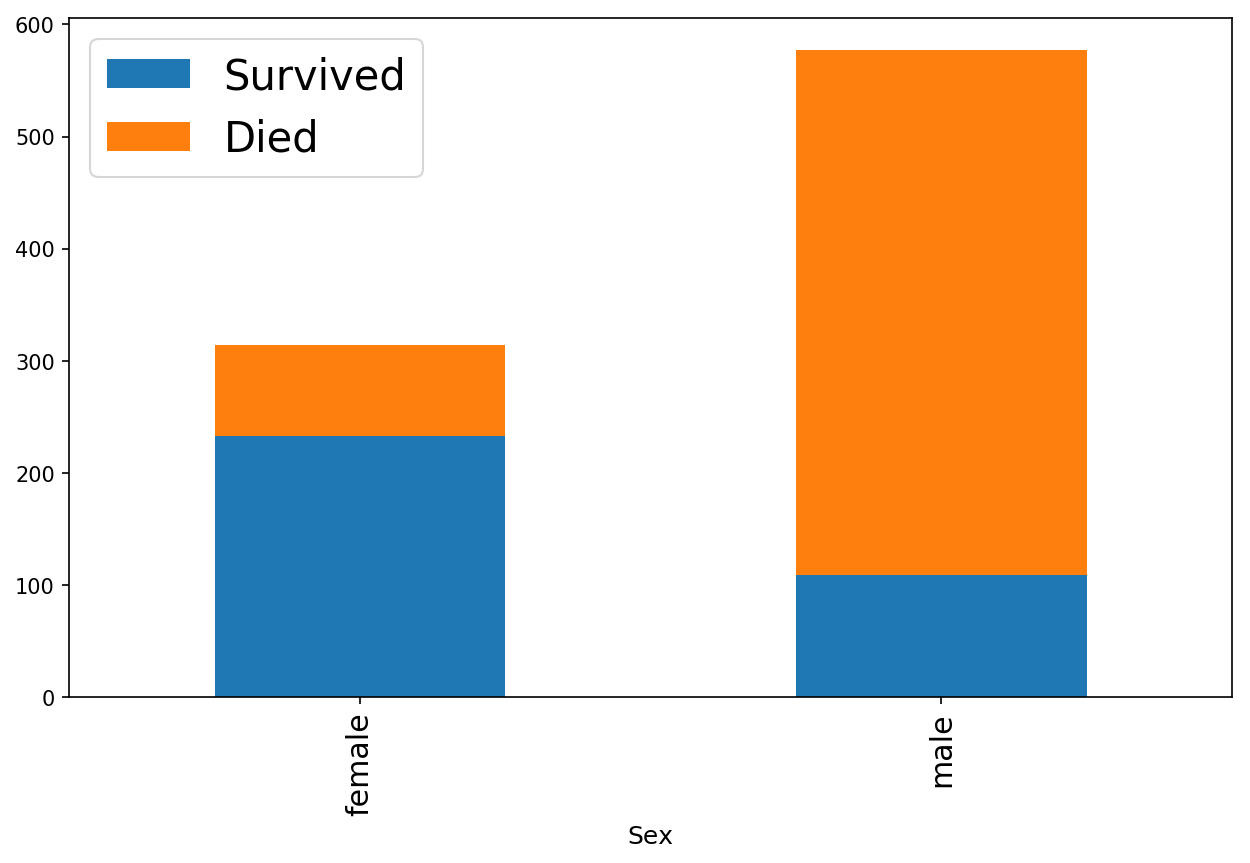

In [13]:
data.groupby('Sex').agg('sum')[['Survived','Died']].plot(kind='bar',stacked=True)

From the above graph it is evident that more male passengers died.

Let's correlate the age with the survival variable.

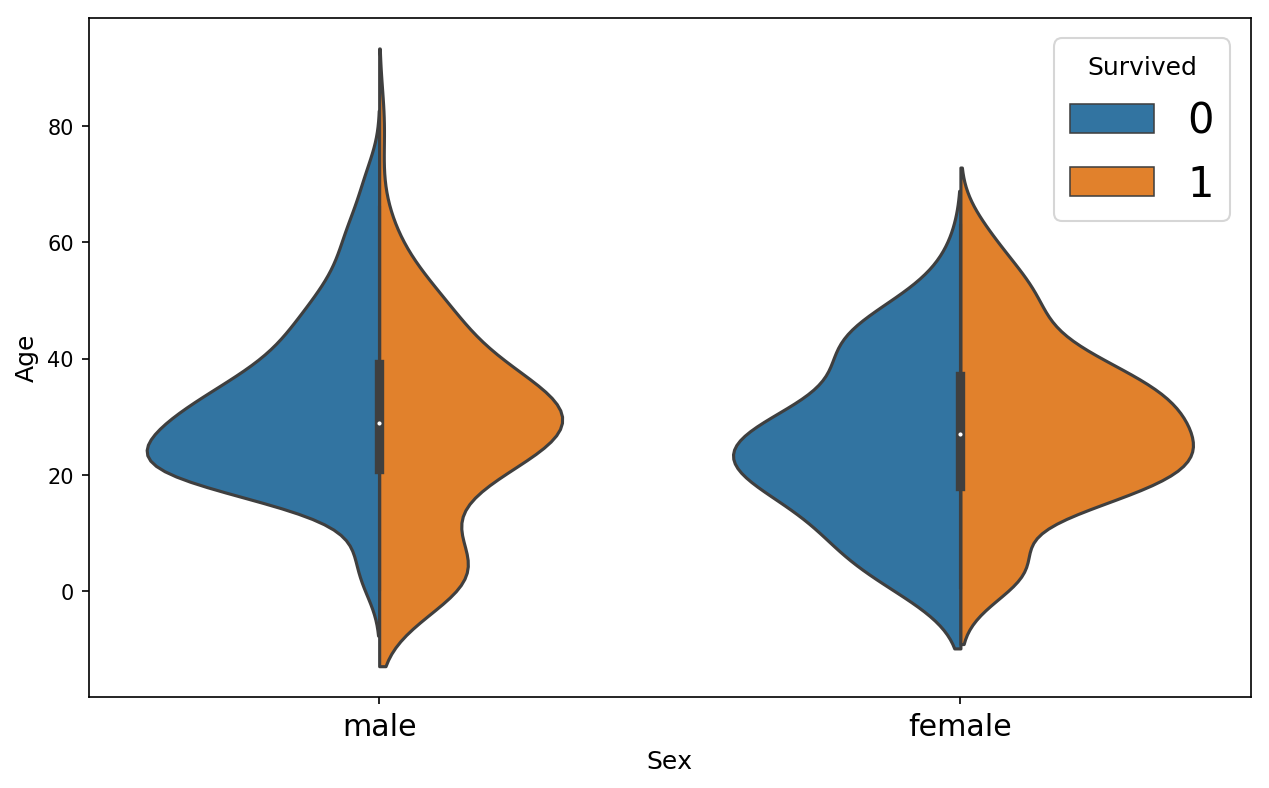

In [14]:
sns.violinplot(x='Sex', y='Age', hue='Survived',data=data,split=True)

we can see men who are between 20 to 40 are survived more compared to older aged men as depicted by the green histogram. Women on the other hand survived more than men, comparatively well on all the age groups.

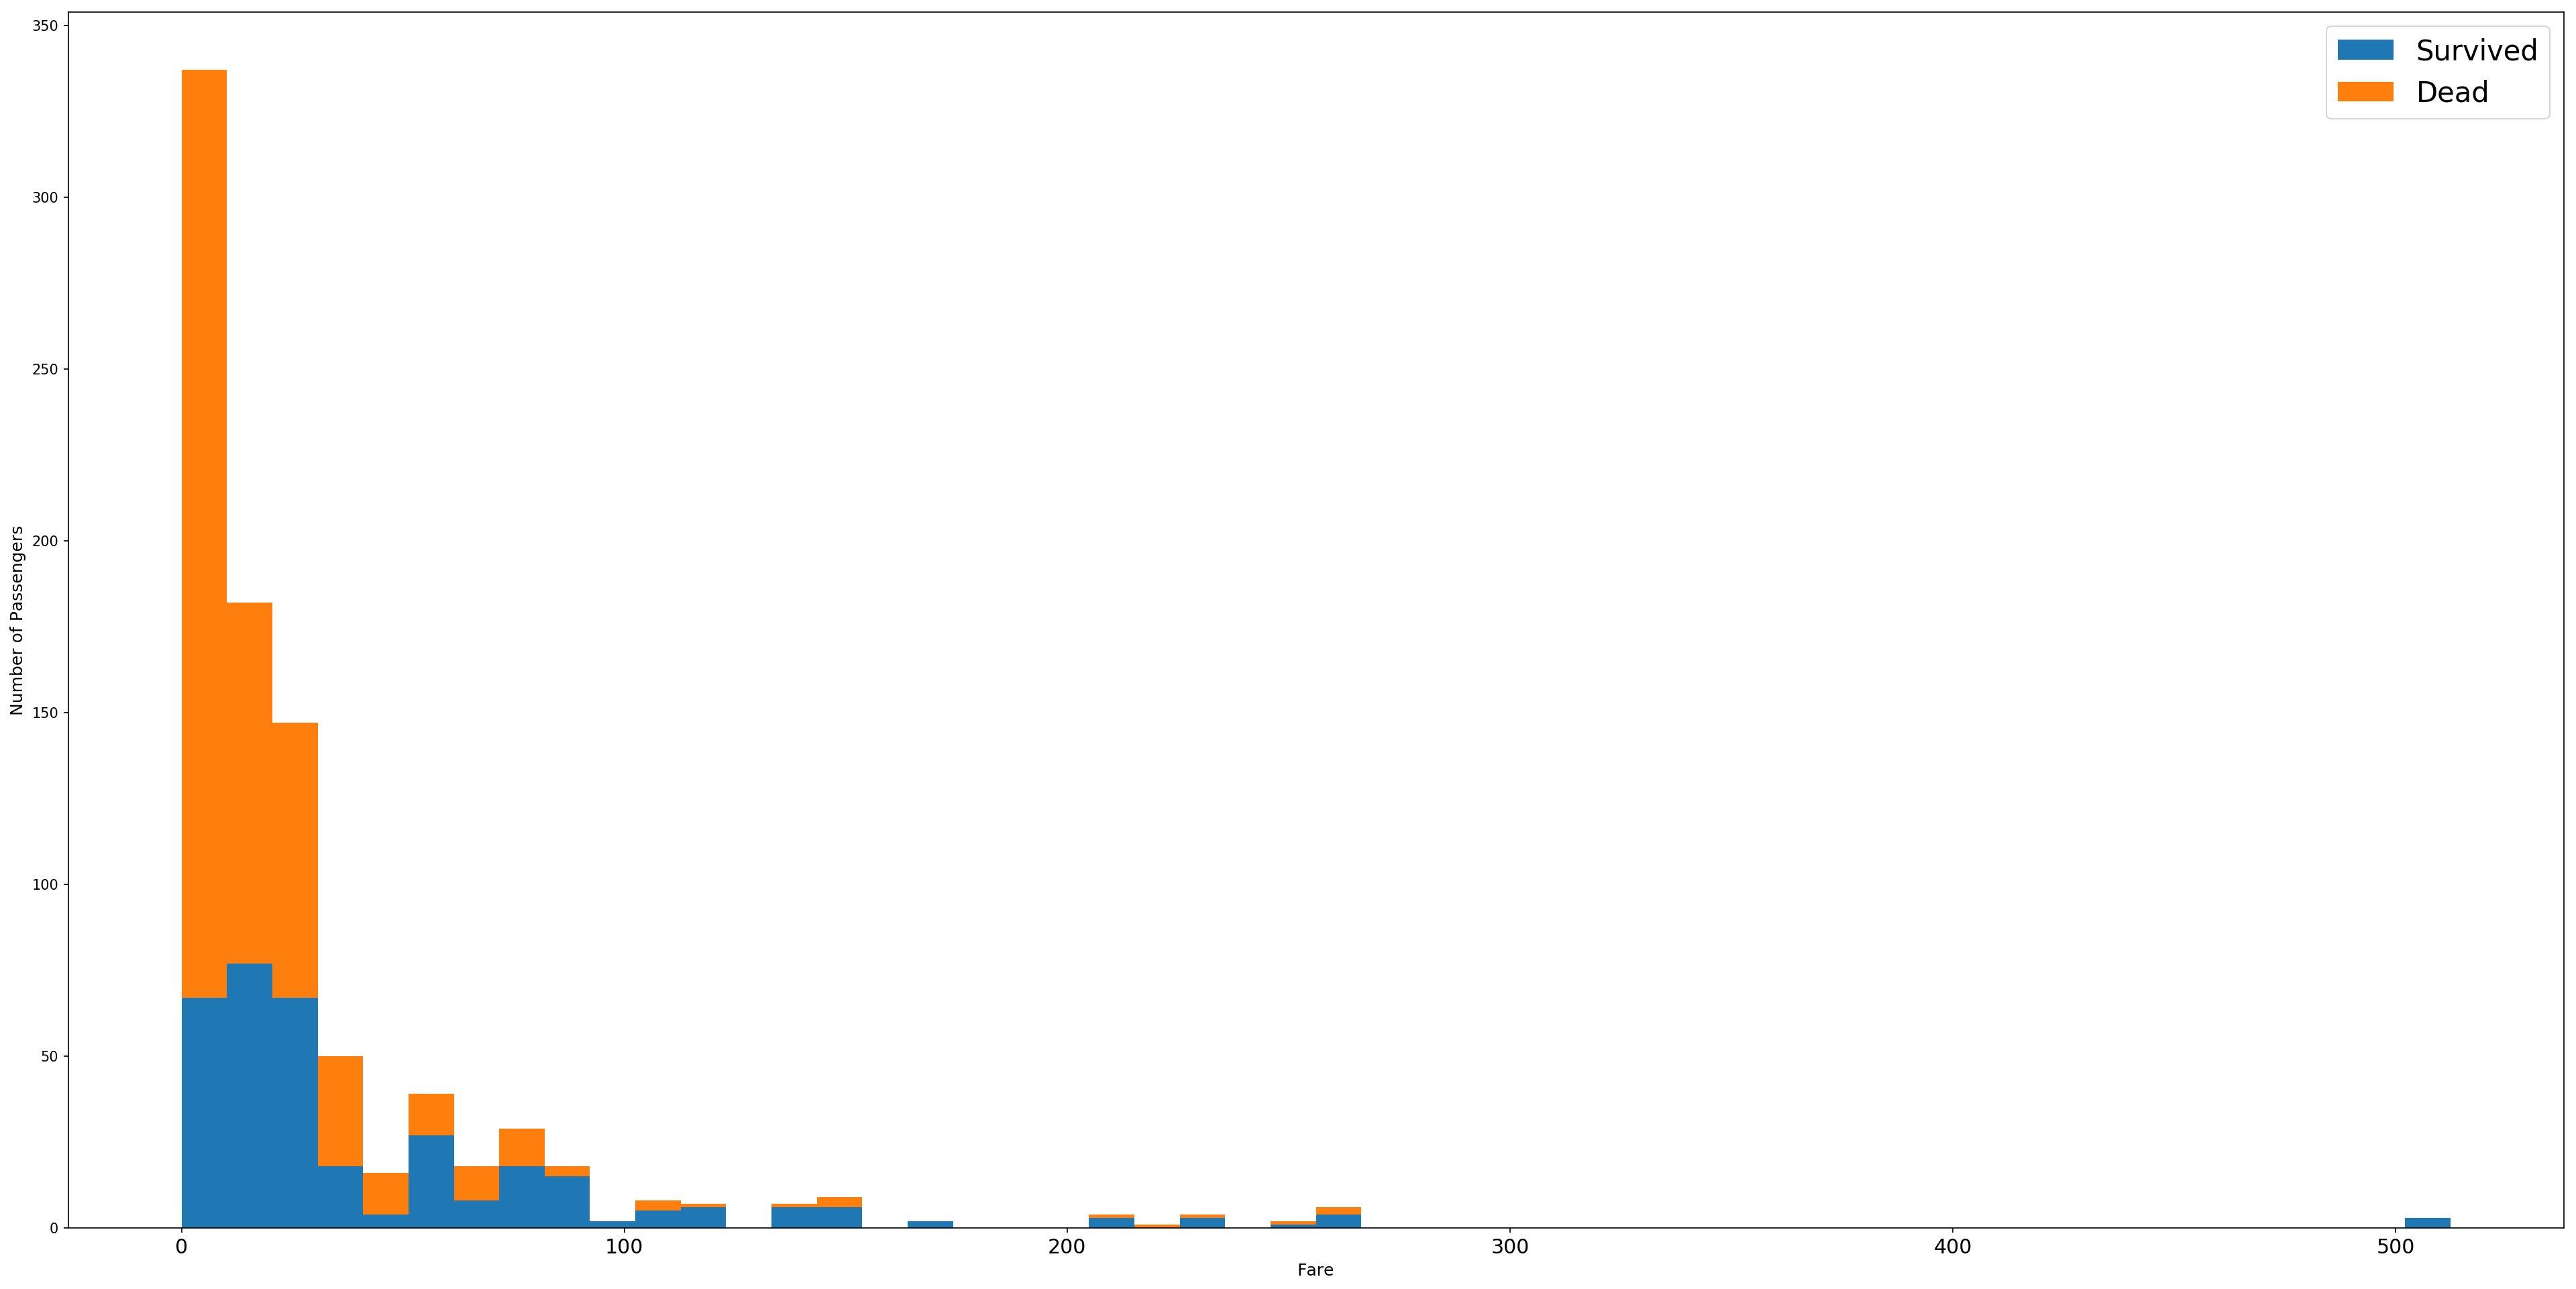

In [15]:
#Check the Fare ticket of each passagener and see how it impact the survival.

figure = plt.figure(figsize=(32,16))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], 
         stacked=True,
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')
plt.legend();

Above graph says passengers with cheaper ticket fares are more likely to die.

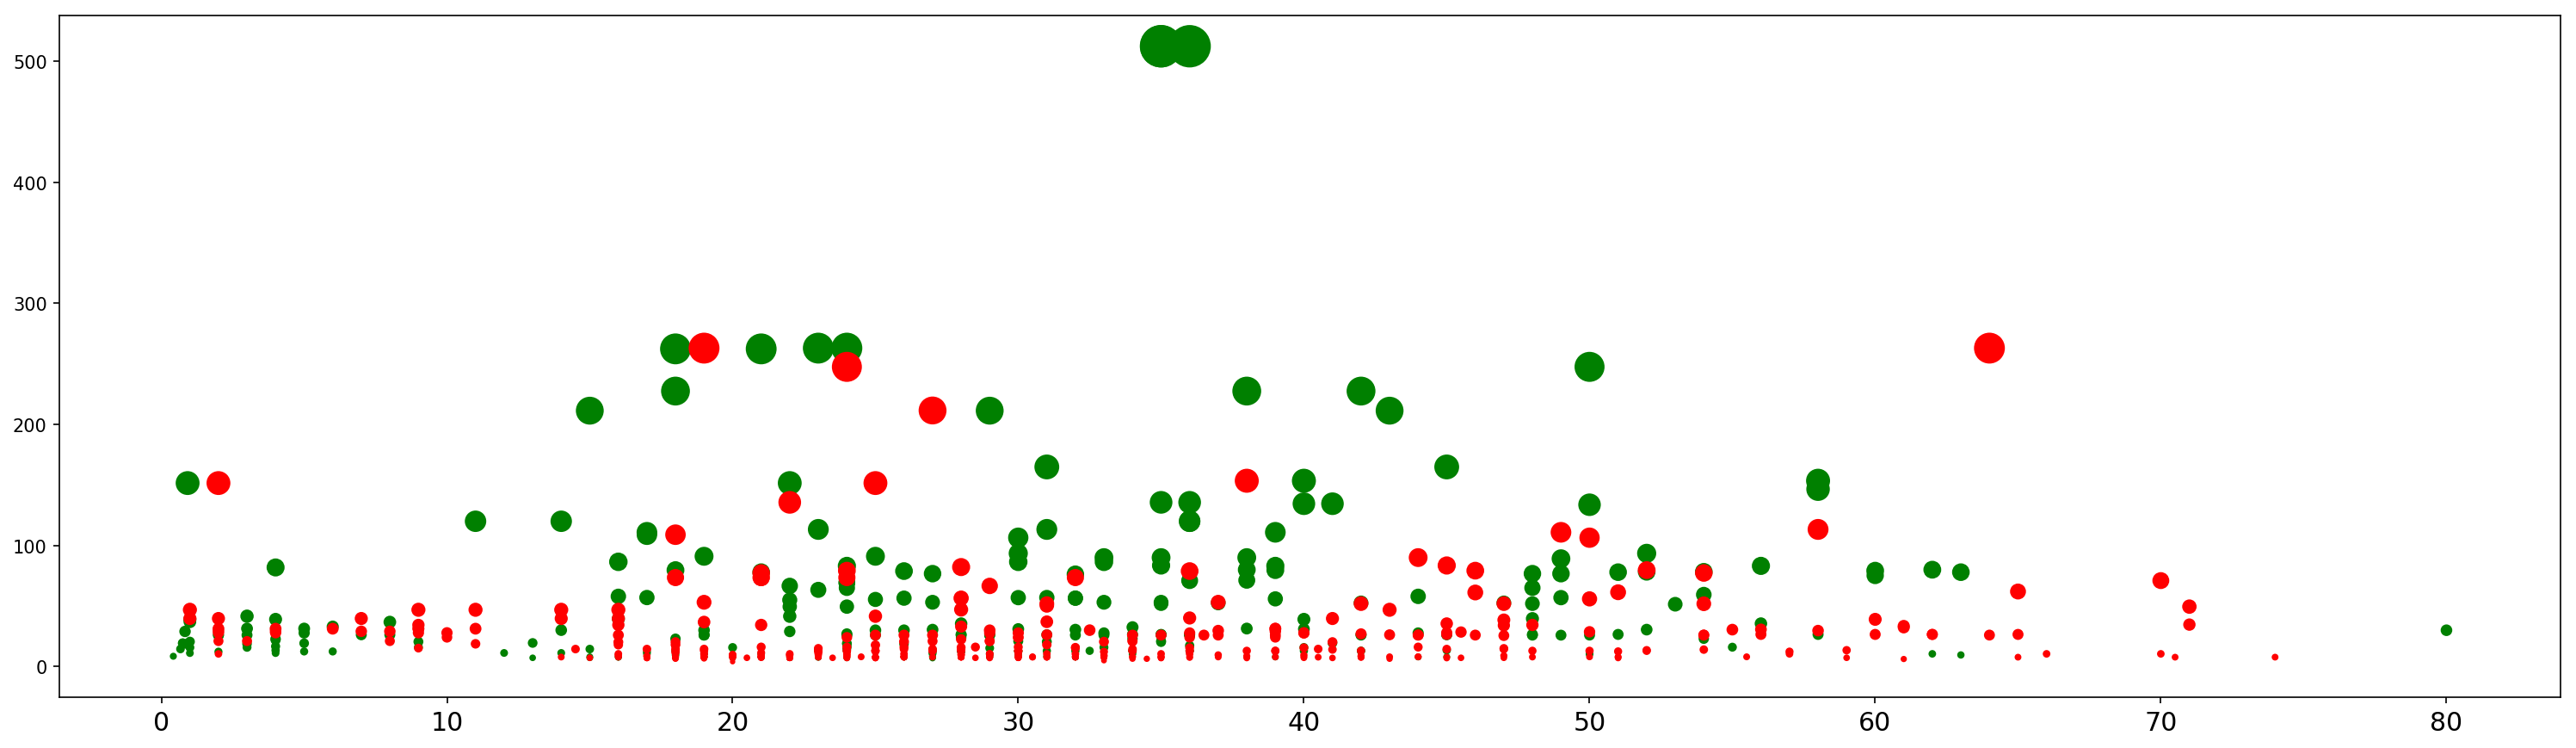

In [16]:
#combining age, fare and survival in one chart.

plt.figure(figsize=(25, 7))
ax = plt.subplot()

ax.scatter(data[data['Survived'] == 1]['Age'], data[data['Survived'] == 1]['Fare'], 
           c='green', s=data[data['Survived'] == 1]['Fare'])
ax.scatter(data[data['Survived'] == 0]['Age'], data[data['Survived'] == 0]['Fare'], 
           c='red', s=data[data['Survived'] == 0]['Fare']);

Size of the circles is proportional to the ticket fare. X-axis = AGE Y-axis = Ticket_Fare Green = Survived Red = Died

Small green dots between x=0 & x=7 : Children who were saved Small red dots between x=10 & x=45 : adults who died and from a lower classes Large green dots between x=20 & x=45 : Adults with larger ticket fares who are sruvived

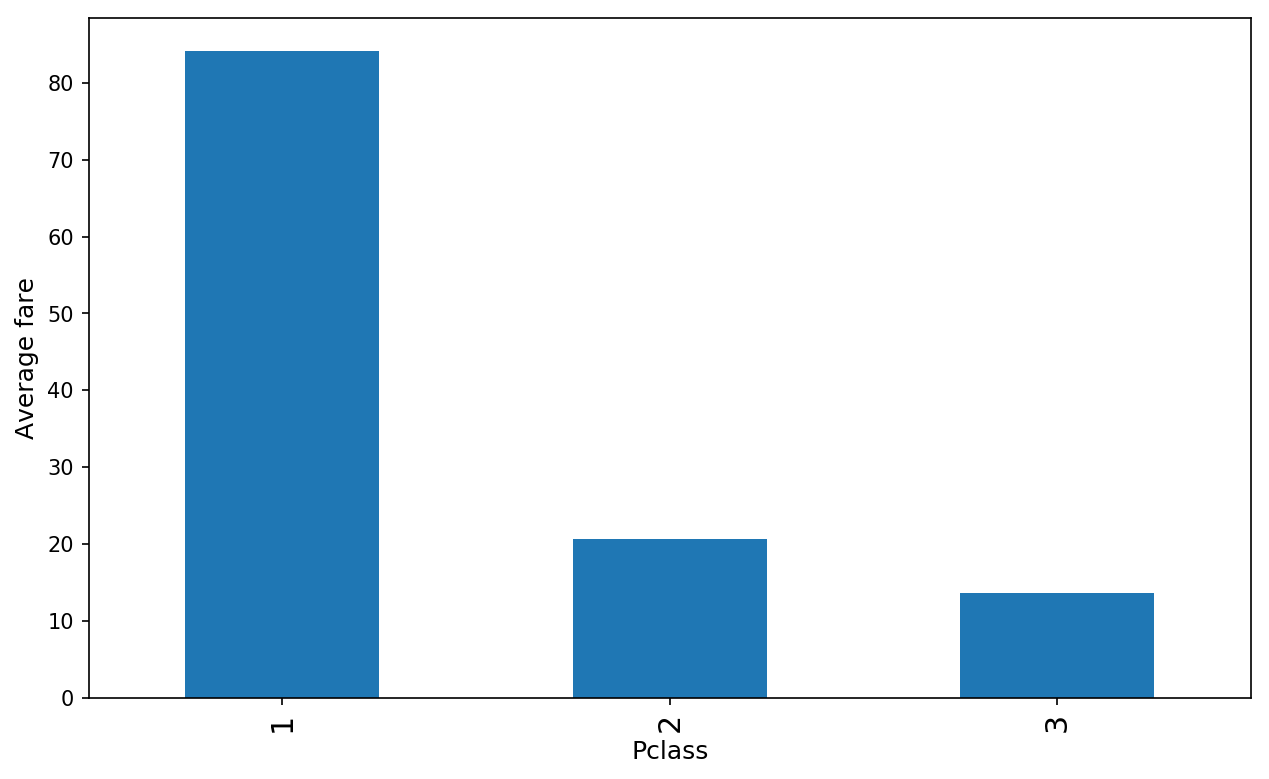

In [17]:
#ticket fare versues class

ax = plt.subplot()
ax.set_ylabel('Average fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar',ax=ax)

##Feature Engineering

In [0]:
#Combining the test and train data to prepare the data for modeling.

x_train = train_raw.drop(['Survived'],1)
y_train = train_raw['Survived']
x_test = test_raw

In [19]:
df_combined = x_train.append(x_test)
df_combined.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(1309, 12)

In [0]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [21]:
display_all(df_combined.tail().T)

,413,414,415,416,417
Age,NaN,39,38.5,NaN,NaN
Cabin,NaN,C105,NaN,NaN,NaN
Died,NaN,NaN,NaN,NaN,NaN
Embarked,S,C,S,S,C
Fare,8.05,108.9,7.25,8.05,22.3583
Name,"Spector, Mr. Woolf","Oliva y Ocana, Dona. Fermina","Saether, Mr. Simon Sivertsen","Ware, Mr. Frederick","Peter, Master. Michael J"
Parch,0,0,0,0,1
PassengerId,1305,1306,1307,1308,1309
Pclass,3,1,3,3,3
Sex,male,female,male,male,male


In [0]:
#train_cats module from fastai, which changes the strings in a dataframe to a 
#categorical values

train_cats(df_combined)

In [23]:
#Check the missing data %
display_all(df_combined.isnull().sum().sort_index()/len(df_combined))

Age            0.200917
Cabin          0.774637
Died           0.319328
Embarked       0.001528
Fare           0.000764
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Ticket         0.000000
dtype: float64

In [24]:
#proc_df takes a data frame df and splits off the response variable, and
#changes the df into an entirely numeric dataframe. In this case am excluding the 
# fields in ignore_flds as they need further processing.

df,y,nas = proc_df(df_combined,y_fld=None,ignore_flds=['Age','Name','Embarked','Cabin','Parch',
                                                      'SibSp'])
df.head()

,Age,Name,Embarked,Cabin,Parch,SibSp,Died,Fare,PassengerId,Pclass,Sex,Ticket,Died_na,Fare_na
0,22.0,"Braund, Mr. Owen Harris",S,NaN,0,1,1.0,7.2500,1,3,2,721,False,False
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C,C85,0,1,0.0,71.2833,2,1,1,817,False,False
2,26.0,"Heikkinen, Miss. Laina",S,NaN,0,0,0.0,7.9250,3,3,1,915,False,False
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",S,C123,0,1,0.0,53.1000,4,1,1,66,False,False
4,35.0,"Allen, Mr. William Henry",S,NaN,0,0,1.0,8.0500,5,3,2,650,False,False


##Process Family

In [0]:
def process_family():
    
    global df
    # introducing a new feature : the size of families (including the passenger)
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    
    # introducing other features based on the family size
    df['Singleton'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallFamily'] = df['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    df['LargeFamily'] = df['FamilySize'].map(lambda s: 1 if 5 <= s else 0)    
    return df

In [0]:
df = process_family()

##Process Embarked

In [0]:
def process_embarked():
    global df
    # two missing embarked values - filling them with the most frequent one in the train  set(S)
    df.Embarked.fillna('S', inplace=True)
    # dummy encoding 
    df_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = pd.concat([df, df_dummies], axis=1)
    df.drop('Embarked', axis=1, inplace=True)
#     status('embarked')
    return df

In [0]:
df = process_embarked()

##Process Cabin

In [0]:
def process_cabin():
    global df    
    # replacing missing cabins with U (for Uknown)
    df.Cabin.fillna('T', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    df['Cabin'] = df['Cabin'].map(lambda c: c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')    
    df = pd.concat([df, cabin_dummies], axis=1)

    df.drop('Cabin', axis=1, inplace=True)
#     status('cabin')
    return df

In [0]:
df = process_cabin()

##Get Title From Name

In [0]:
titles = set()
for name in df['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

In [0]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # we extract the title from each name
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    df['Title'] = df.Title.map(Title_Dictionary)
#     status('Title')
    return df

In [33]:
df = get_titles()
df.head()

,Age,Name,Parch,SibSp,Died,Fare,PassengerId,Pclass,Sex,Ticket,Died_na,Fare_na,FamilySize,Singleton,SmallFamily,LargeFamily,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
0,22.0,"Braund, Mr. Owen Harris",0,1,1.0,7.2500,1,3,2,721,False,False,2,0,1,0,0,0,1,0,0,0,0,0,0,0,1,Mr
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0.0,71.2833,2,1,1,817,False,False,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,Mrs
2,26.0,"Heikkinen, Miss. Laina",0,0,0.0,7.9250,3,3,1,915,False,False,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,Miss
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0.0,53.1000,4,1,1,66,False,False,2,0,1,0,0,0,1,0,0,1,0,0,0,0,0,Mrs
4,35.0,"Allen, Mr. William Henry",0,0,1.0,8.0500,5,3,2,650,False,False,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,Mr


##Process Age

In [0]:
#summarize the Age grouped by sex, class and title
grouped_train = df.groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

In [35]:
grouped_median_train.head()

,Sex,Pclass,Title,Age
0,1,1,Miss,30.0
1,1,1,Mrs,45.0
2,1,1,Officer,49.0
3,1,1,Royalty,40.5
4,1,2,Miss,20.0


In [36]:
df.head()

,Age,Name,Parch,SibSp,Died,Fare,PassengerId,Pclass,Sex,Ticket,Died_na,Fare_na,FamilySize,Singleton,SmallFamily,LargeFamily,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
0,22.0,"Braund, Mr. Owen Harris",0,1,1.0,7.2500,1,3,2,721,False,False,2,0,1,0,0,0,1,0,0,0,0,0,0,0,1,Mr
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0.0,71.2833,2,1,1,817,False,False,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,Mrs
2,26.0,"Heikkinen, Miss. Laina",0,0,0.0,7.9250,3,3,1,915,False,False,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,Miss
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0.0,53.1000,4,1,1,66,False,False,2,0,1,0,0,0,1,0,0,1,0,0,0,0,0,Mrs
4,35.0,"Allen, Mr. William Henry",0,0,1.0,8.0500,5,3,2,650,False,False,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,Mr


In [0]:
#Assing the value of age for missing values based on the group.
#If a title is miising then the age will be assigned based on sex and class.

def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    if np.isnan(grouped_median_train[condition]['Age'].values[0]):
        print('true')
        condition = (
            (grouped_median_train['Sex'] == row['Sex']) & 
            (grouped_median_train['Pclass'] == row['Pclass'])
        )

    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global df
    # a function that fills the missing values of the Age variable
    df['Age'] = df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
#     status('age')
    return df

In [0]:
df = process_age()

In [39]:
#Check for missing values.

display_all(df.isnull().sum().sort_index()/len(df))

Age            0.000000
Cabin_A        0.000000
Cabin_B        0.000000
Cabin_C        0.000000
Cabin_D        0.000000
Cabin_E        0.000000
Cabin_F        0.000000
Cabin_G        0.000000
Cabin_T        0.000000
Died           0.000000
Died_na        0.000000
Embarked_C     0.000000
Embarked_Q     0.000000
Embarked_S     0.000000
FamilySize     0.000000
Fare           0.000000
Fare_na        0.000000
LargeFamily    0.000000
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Singleton      0.000000
SmallFamily    0.000000
Ticket         0.000000
Title          0.000764
dtype: float64

In [40]:
df[df.Title.isnull()]

,Age,Name,Parch,SibSp,Died,Fare,PassengerId,Pclass,Sex,Ticket,Died_na,Fare_na,FamilySize,Singleton,SmallFamily,LargeFamily,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
414,39.0,"Oliva y Ocana, Dona. Fermina",0,0,1.0,108.9,1306,1,1,835,True,False,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,NaN


##Process Name

In [0]:
def process_names():
    global df
    # we clean the Name variable
    df.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(df['Title'], prefix='Title')
    df = pd.concat([df, titles_dummies], axis=1)
    
    # removing the title variable
    df.drop('Title', axis=1, inplace=True)
    
#     status('names')
    return df

In [0]:
df = process_names()

In [43]:
df.head()

,Age,Parch,SibSp,Died,Fare,PassengerId,Pclass,Sex,Ticket,Died_na,Fare_na,FamilySize,Singleton,SmallFamily,LargeFamily,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,22.0,0,1,1.0,7.2500,1,3,2,721,False,False,2,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,38.0,0,1,0.0,71.2833,2,1,1,817,False,False,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,26.0,0,0,0.0,7.9250,3,3,1,915,False,False,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,35.0,0,1,0.0,53.1000,4,1,1,66,False,False,2,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,35.0,0,0,1.0,8.0500,5,3,2,650,False,False,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [44]:
#Now no null vlaues
display_all(df.isnull().sum().sort_index()/len(df))

Age              0.0
Cabin_A          0.0
Cabin_B          0.0
Cabin_C          0.0
Cabin_D          0.0
Cabin_E          0.0
Cabin_F          0.0
Cabin_G          0.0
Cabin_T          0.0
Died             0.0
Died_na          0.0
Embarked_C       0.0
Embarked_Q       0.0
Embarked_S       0.0
FamilySize       0.0
Fare             0.0
Fare_na          0.0
LargeFamily      0.0
Parch            0.0
PassengerId      0.0
Pclass           0.0
Sex              0.0
SibSp            0.0
Singleton        0.0
SmallFamily      0.0
Ticket           0.0
Title_Master     0.0
Title_Miss       0.0
Title_Mr         0.0
Title_Mrs        0.0
Title_Officer    0.0
Title_Royalty    0.0
dtype: float64

##Build and Train the Model

In [45]:
#Seperate out the train & test data

x_train = df[:891].copy()
x_test = df[891:].copy()
x_train.shape,x_test.shape

((891, 32), (418, 32))

In [0]:
#split the tarin data into train and valid set
def split_vals(a,n): return a[:n], a[n:]
valid_count =60
n_trn = len(x_train)-valid_count
x_train1, x_valid1 = split_vals(x_train, n_trn)
y_train1, y_valid1 = split_vals(y_train, n_trn)

In [47]:
x_train1.shape,y_train1.shape,x_valid1.shape,y_valid1.shape

((831, 32), (831,), (60, 32), (60,))

In [48]:
m = RandomForestClassifier(n_estimators=180,min_samples_leaf=3,max_features=0.5,n_jobs=-1)
m.fit(x_train1,y_train1)
m.score(x_train1,y_train1)

1.0

##Model Evaluation

In [49]:
y_predict=m.predict(x_valid1)
from sklearn.metrics import accuracy_score
accuracy_score(y_valid1,y_predict)

1.0

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_valid1,y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        22

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [51]:
#confusion Matrix
print(confusion_matrix(y_valid1,y_predict))

[[38  0]
 [ 0 22]]


In [52]:
#Feature importance
fi = rf_feat_importance(m, x_train1); fi[:10]

,cols,imp
3,Died,0.820022
28,Title_Mr,0.079937
7,Sex,0.051476
6,Pclass,0.007412
8,Ticket,0.006002
11,FamilySize,0.005951
4,Fare,0.004903
29,Title_Mrs,0.004013
27,Title_Miss,0.003965
25,Cabin_T,0.003654


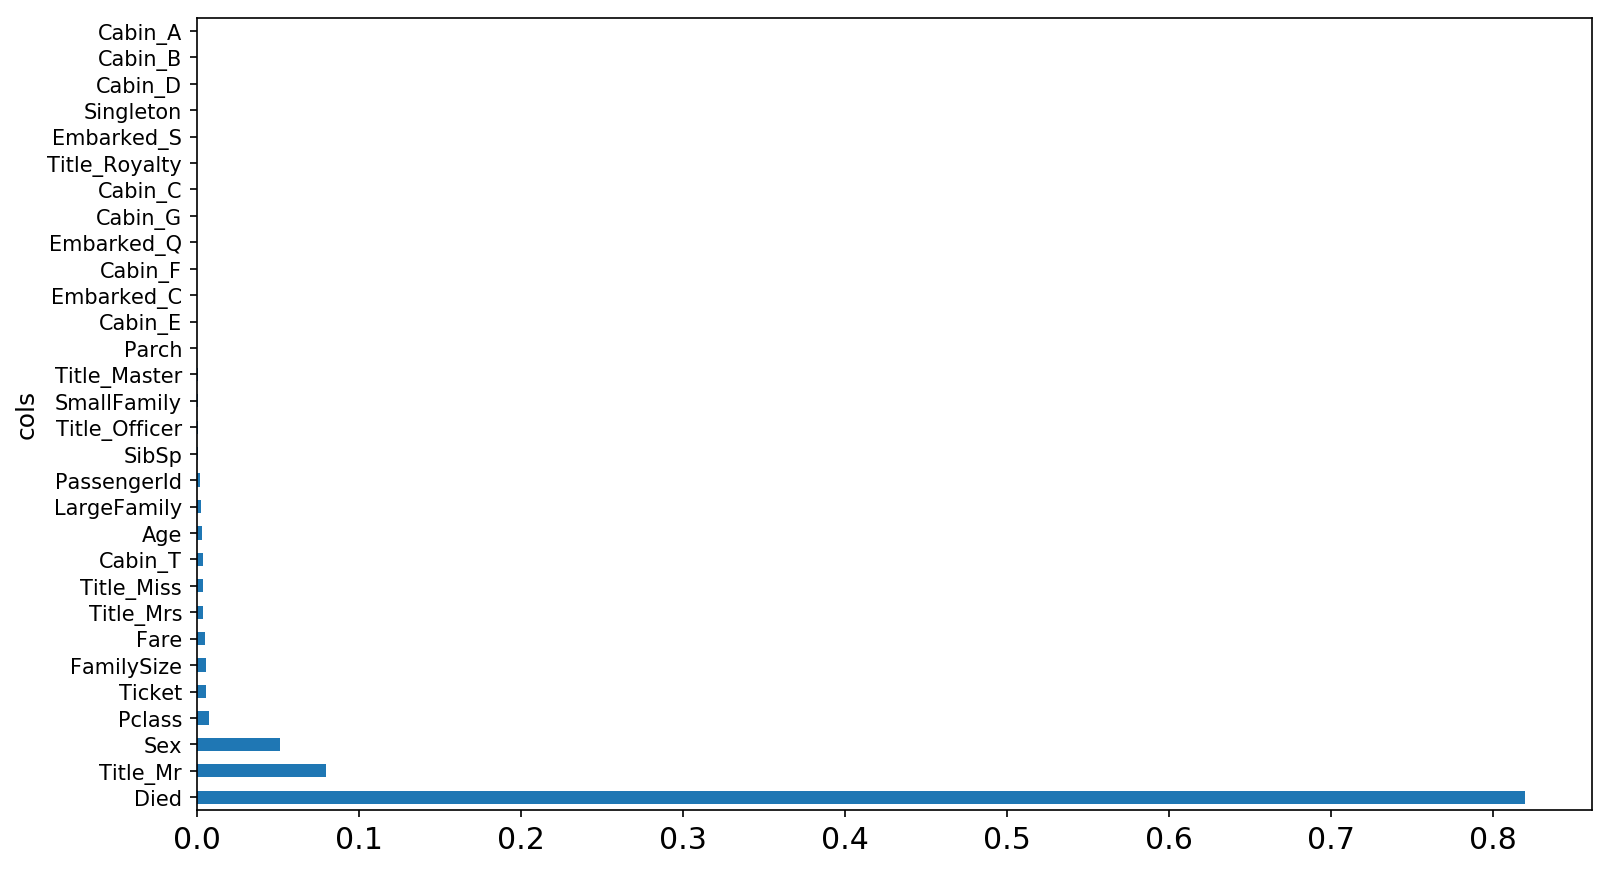

In [53]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [54]:
# Keeping only the variables which are significant for the model(>0.01)
to_keep = fi[fi.imp>0.01].cols; len(to_keep)
to_keep

3         Died
28    Title_Mr
7          Sex
Name: cols, dtype: object

##Our Final Model

In [55]:
#Now training the model on the entire data with only the important features.
x_train = x_train[to_keep]
x_train

,Died,Title_Mr,Sex
0,1.0,1,2
1,0.0,0,1
2,0.0,0,1
3,0.0,0,1
4,1.0,1,2
5,1.0,1,2
6,1.0,1,2
7,1.0,0,2
8,0.0,0,1
9,0.0,0,1


In [56]:
m = RandomForestClassifier(n_estimators=200,min_samples_leaf=3,max_features=0.5,n_jobs=-1)
m.fit(x_train,y_train)
m.score(x_train,y_train)

1.0

**We could notice that the score has increased after removing some featurs and training on the complete data.**

##Run the Model on the Test Data

In [0]:
x_test = x_test[to_keep]
output=m.predict(x_test).astype(int)

In [58]:
output.size

418

##Save the output predictions in the requried format and submit it to Kaggle!!

In [0]:
aux=pd.read_csv(io.BytesIO(uploaded['test.csv']),low_memory=False)
df_output = pd.DataFrame()
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('titanic_fastai2.csv', index=False)



In [0]:
files.download('titanic_fastai2.csv')